# 1. 데이터, 라이브러리 불러오기

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib.pyplot import style
import numpy as np

# 스타일 설정
style.use('seaborn')

# 한글 폰트 설정
if (platform.system() == 'Windows'):
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')

# 음수(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False 

#경고무시
import warnings
warnings.filterwarnings(action='ignore') 

In [90]:
df = pd.read_csv('cleand preprocessed2.csv')

In [91]:
df.columns

Index(['구분', '악궁구조', '나이', '성별', '비뚠니', '1년이내스케일링', '사랑니', '시린니', '구취',
       '치아흔들림', '흡연', '탄산음료섭취', '잇몸부종,통증', '양치시간(분)', '하루양치질(회)', '전체회차',
       '진행된회차', '추천칫솔', '추천치약', '진단년', '진단월', '진단일', '진단시', '진단요일', '나쁜습관',
       '바뀔 수 없는 구강구조', '치아 상황', '오전', '오후', '저녁', '밤/새벽', 'Log_나이', '날짜'],
      dtype='object')

In [92]:
import copy
df2 = copy.deepcopy(df)

# 2. PCA

## 2-1 PCA (주성분 분석-차원축소 기법)

In [93]:
# 필요없는 컬럼 제거
del df['추천칫솔']
del df['추천치약']
del df['나이']
del df['날짜']

In [94]:
# 나중에 비교를 위한 파생변수 컬럼도 복사 후 제거를 해둡니다.
a = df['나쁜습관']
b = df['바뀔 수 없는 구강구조']
c = df['치아 상황']

del df['나쁜습관']
del df ['바뀔 수 없는 구강구조']
del df ['치아 상황']


In [95]:
# 군집화를 진행하기에 앞서 수월한 시각화 및 설명력을 첨부하기 위하여 PCA를 통해 변수를 2개로 압축해보자.
# 필요 라이브러리를 불러옵니다.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 정규화 진행
# 객체 생성
scaler = StandardScaler()

# 데이터 학습
scaler.fit(df)

# 변환
scaler_data = scaler.transform(df)

# 객체 생성
pca = PCA(n_components = 2)

# PCA 학습시키기
pca.fit(scaler_data)

# 결과값 확인
pca.transform(scaler_data)

array([[ 0.94561276,  0.58145669],
       [ 0.27463446, -0.03750498],
       [ 1.95090833,  0.88335201],
       ...,
       [ 2.16093399, -3.34757555],
       [ 1.37943938, -3.30131181],
       [ 1.39437384, -3.30084606]])

In [96]:
# 데이터 프레임 형태로 변환
data2 = pd.DataFrame(data = pca.transform(scaler_data), columns = ['pc1', 'pc2'])
data2

,pc1,pc2
0,0.945613,0.581457
1,0.274634,-0.037505
2,1.950908,0.883352
3,0.771129,0.828039
4,0.771129,0.828039
...,...,...
3938,1.298300,-3.179702
3939,1.394374,-3.300846
3940,2.160934,-3.347576
3941,1.379439,-3.301312


## 2-2 Elbow point

In [97]:
# Inertia value는 군집화가된 후에, 각 중심점에서 군집의 데이타간의 거리를 합산한것이으로 
# 군집의 응집도를 나타내는 값이다, 이 값이 작을 수록 응집도가 높게 군집화가 잘되었다고 평가할 수 있다.

# 라이브러리 불러오기
from sklearn.cluster import KMeans

inertia_arr = []
k_range = range(2,15)

for k in k_range:
    
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(data2)
    inertia = Kmeans.inertia_
    
    print('k:', k, 'inertia:', inertia)
    inertia_arr.append(inertia)
    
inertia_arr = np.array(inertia_arr)

k: 2 inertia: 12062.106054378677
k: 3 inertia: 6275.307227444515
k: 4 inertia: 3956.0386560275797
k: 5 inertia: 3189.0909700516813
k: 6 inertia: 2660.33118759941
k: 7 inertia: 2389.7561655370528
k: 8 inertia: 2123.3904503625126
k: 9 inertia: 1909.8222486395362
k: 10 inertia: 1757.3368202895197
k: 11 inertia: 1634.9802098797636
k: 12 inertia: 1510.1471362917728
k: 13 inertia: 1394.1700118847755
k: 14 inertia: 1300.70308662889


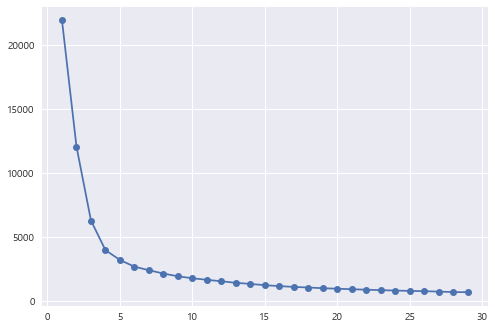

In [98]:
# elbow point 확인

x = [] # k가 몇개인지
y = [] # 응집도가 몇인지

for k in range(1,30) :
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(data2)
    
    x.append(k)
    y.append(kmeans.inertia_)
    
# 그래프 그리기
plt.plot(x, y, '-o')

k는 3,4가 적당해 보임.

## 2-2 Silhouette 계수

군집타당성지표인 실루엣 점수를 이용한다.  
1에 가까울 수록 적절한 군집화가 되었다고 판단한다.

In [99]:
from sklearn.metrics import silhouette_score

k_range = range(2,10)
best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=200)
    kmeans.fit(data2)
    clusters = kmeans.predict(data2)
    
    score =silhouette_score(data2, clusters)
    print('k:', k, 'score:',score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
print('best n:', best_n, 'best_score:' ,best_silhouette_score)

k: 2 score: 0.47153703172390365
k: 3 score: 0.5259641453010552
k: 4 score: 0.5193274175217997
k: 5 score: 0.42454944324792127
k: 6 score: 0.4205161256737096
k: 7 score: 0.4096171859381913
k: 8 score: 0.3991268612705396
k: 9 score: 0.386972762357867
best n: 3 best_score: 0.5259641453010552


best k는 3이다. 

# 3. Kmeans Clustering

Text(0.5, 0, 'k=4')

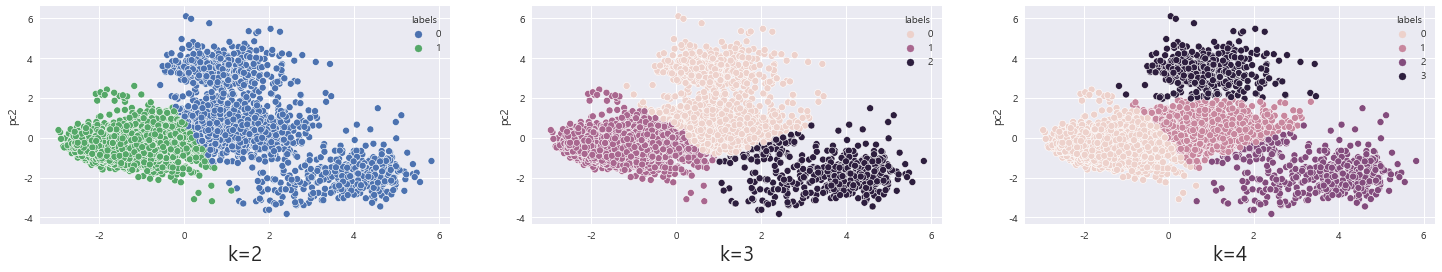

In [100]:
# k=2,3,4 군집화
fig, ax = plt.subplots(ncols=3, figsize=(25,4))

kmeans = KMeans(n_clusters = 2)
kmeans.fit(data2)
data2['labels'] = kmeans.predict(data2)
aa=sns.scatterplot(ax=ax[0], x = 'pc1', y = 'pc2', hue = 'labels', data = data2)
aa.set_xlabel("k=2", fontsize = 20)

kmeans = KMeans(n_clusters = 3)
kmeans.fit(data2)
data2['labels'] = kmeans.predict(data2)
aa=sns.scatterplot(ax=ax[1], x = 'pc1', y = 'pc2', hue = 'labels', data = data2)
aa.set_xlabel("k=3", fontsize = 20)

kmeans = KMeans(n_clusters = 4)
kmeans.fit(data2)
data2['labels'] = kmeans.predict(data2)
aa=sns.scatterplot(ax=ax[2], x = 'pc1', y = 'pc2', hue = 'labels', data = data2)
aa.set_xlabel("k=4", fontsize = 20)

# 4. 클러스터링 해석

## 4-1 고객 그룹별 차트확인

In [101]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(data2)
data2['labels'] = kmeans.predict(data2)

In [102]:
# 맨 처음 떼어 두었던 medv 컬럼을 추가합니다.
data2['나쁜습관'] = a
data2['바뀔 수 없는 구강구조'] = b
data2['치아 상황'] = c

data2.head()

,pc1,pc2,labels,나쁜습관,바뀔 수 없는 구강구조,치아 상황
0,0.945613,0.581457,1,0,0,2
1,0.274634,-0.037505,1,0,0,0
2,1.950908,0.883352,1,0,0,3
3,0.771129,0.828039,1,1,0,1
4,0.771129,0.828039,1,1,0,1


In [103]:
# 시각화를 위해 각 그룹별 값을 따로 변수로 생성

habit_0 = data2[data2['labels']==0]['나쁜습관'].mean()
habit_1 = data2[data2['labels']==1]['나쁜습관'].mean()
habit_2 = data2[data2['labels']==2]['나쁜습관'].mean()
habit_3 = data2[data2['labels']==3]['나쁜습관'].mean()

oral_0 = data2[data2['labels']==0]['바뀔 수 없는 구강구조'].mean()
oral_1 = data2[data2['labels']==1]['바뀔 수 없는 구강구조'].mean()
oral_2 = data2[data2['labels']==2]['바뀔 수 없는 구강구조'].mean()
oral_3 = data2[data2['labels']==3]['바뀔 수 없는 구강구조'].mean()

teeth_0 = data2[data2['labels']==0]['치아 상황'].mean()
teeth_1 = data2[data2['labels']==1]['치아 상황'].mean()
teeth_2 = data2[data2['labels']==2]['치아 상황'].mean()
teeth_3 = data2[data2['labels']==3]['치아 상황'].mean()


Text(0.5, 0, '치아 상황')

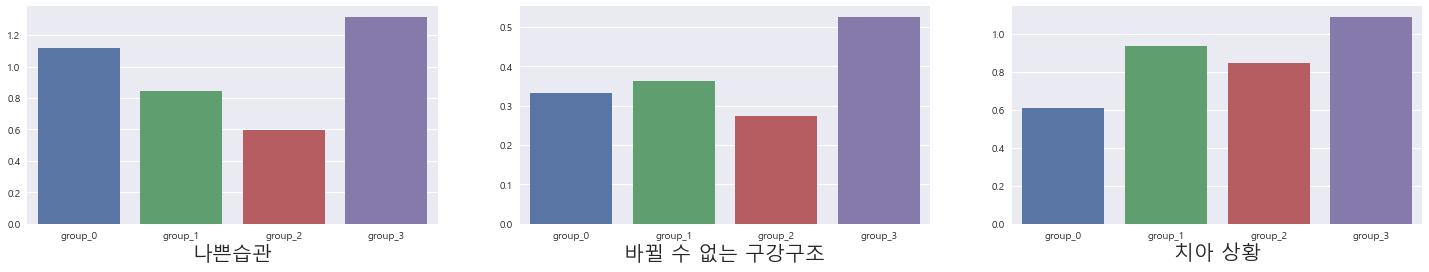

In [104]:
# 그룹별 파생변수 그래프

fig, ax = plt.subplots(ncols=3, figsize=(25,4))

aa = sns.barplot(x = ['group_0','group_1', 'group_2','group_3'], y = [habit_0, habit_1, habit_2, habit_3] , ax=ax[0])
aa.set_xlabel("나쁜습관", fontsize = 20)

aa = sns.barplot(x = ['group_0','group_1', 'group_2','group_3'], y = [oral_0, oral_1, oral_2, oral_3] , ax=ax[1])
aa.set_xlabel('바뀔 수 없는 구강구조', fontsize = 20)

aa = sns.barplot(x = ['group_0','group_1', 'group_2','group_3'], y = [teeth_0, teeth_1, teeth_2, teeth_3] , ax=ax[2])
aa.set_xlabel('치아 상황', fontsize = 20)

In [105]:
import numpy as np
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [106]:
# 레이더차트용 데이터프레임 - 그룹별 파생변수 평균
RC = pd.DataFrame()
RC['habit'] = [habit_0, habit_1, habit_2, habit_3] 
RC['oral'] = [oral_0, oral_1, oral_2, oral_3]
RC['teeth'] = [teeth_0, teeth_1, teeth_2, teeth_3]
RC['group'] = ['group_0','group_1', 'group_2','group_3']
RC

,habit,oral,teeth,group
0,1.119738,0.332086,0.606174,group_0
1,0.846715,0.361835,0.932221,group_1
2,0.594533,0.273349,0.845103,group_2
3,1.316953,0.525799,1.088452,group_3


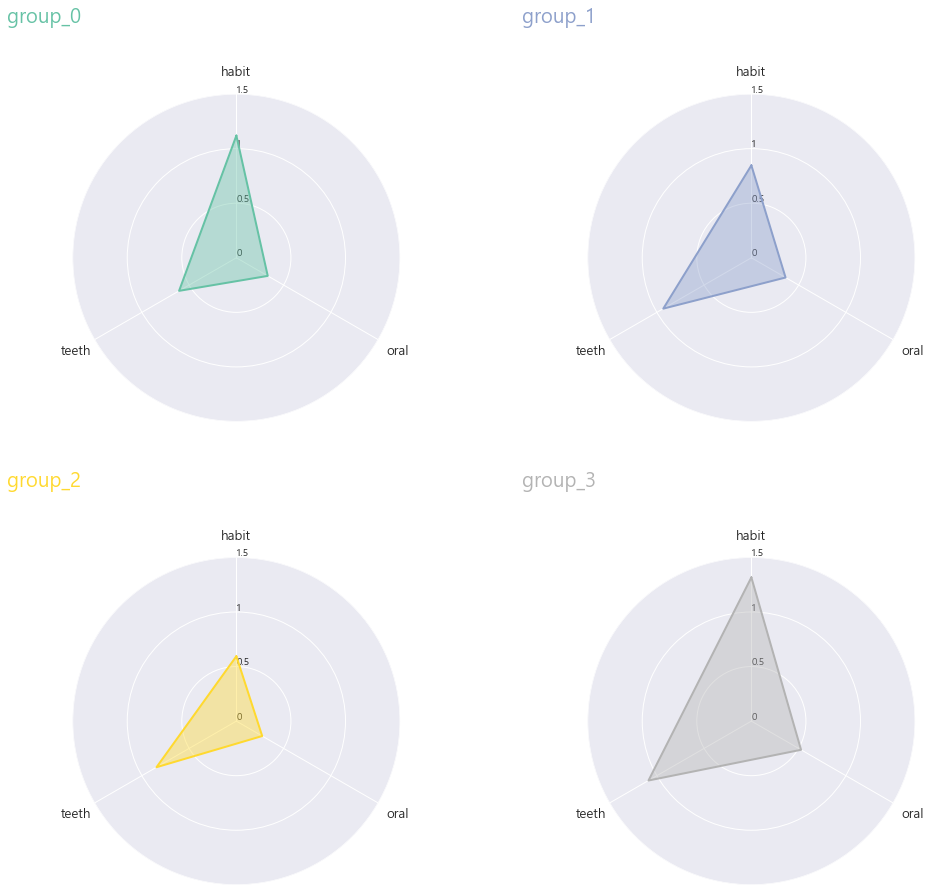

In [107]:
## 레이더 차트 그리기
labels = RC.columns[:3]
num_labels = len(labels)
    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
my_palette = plt.cm.get_cmap("Set2", len(RC.index))
 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white')
 
for i, row in RC.iterrows():
    color = my_palette(i)
    data = RC.iloc[i].drop(['group']).tolist()
    data += data[:1]
    
    ax = plt.subplot(3,2,i+1, polar=True)
    ax.set_theta_offset(pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준다.
 
    ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
    plt.yticks([0,0.5,1,1.5],['0','0.5','1', '1.5'], fontsize=10) ## y축 눈금 설정
    plt.ylim(0,1.5)
    
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid') ## 레이더 차트 출력
    ax.fill(angles, data, color=color, alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
    plt.title(RC['group'][i], size=20, color=color,x=-0.2, y=1.2, ha='left') ## 타이틀은 캐릭터 클래스로 한다.
 
plt.tight_layout(pad=5) ## subplot간 패딩 조절
plt.show()

elbow point는 3,4이고, 실루엣 계수는 3이었다.  
K=2,3,4 각각 그려본 결과  
K=4 일때 레이더 차트를 확인해 보니 실제 비즈니스에서 쓰일 수 있는 고객분류가 가장 잘 되는 것으로 보임.

## 4-2 고객 그룹별 세부사항 확인


참고  
1. 흡연, 탄산음료섭취, 양치시간 1분이하, 1회이하 -> 나쁜 습관
2. 사랑니, 비뚠이 -> 바뀔 수 없는 구강구조 
3. 구취, 치아 흔들림, 시린니, 잇몸부종 => 치아 상황 

### 4-2-1 group_0
습관이 나쁜데, 구강상태가 별로 나쁘지 않을경우  
: group 0은 제대로 답변을 한것인지, 이들이 여성/ 남성/ 연령은 어떤지   
주로 어떤 habit이 안좋다고 마크된 것인지 

In [108]:
# 나눠진 그룹 라벨을 원래 df에 붙이기
df2['group'] = data2['labels']

In [124]:
# group_1의 특성 파악
pd.set_option('display.max_columns', 35)
d1 = df2[df2['group']==0]

<AxesSubplot:xlabel='하루양치질(회)', ylabel='count'>

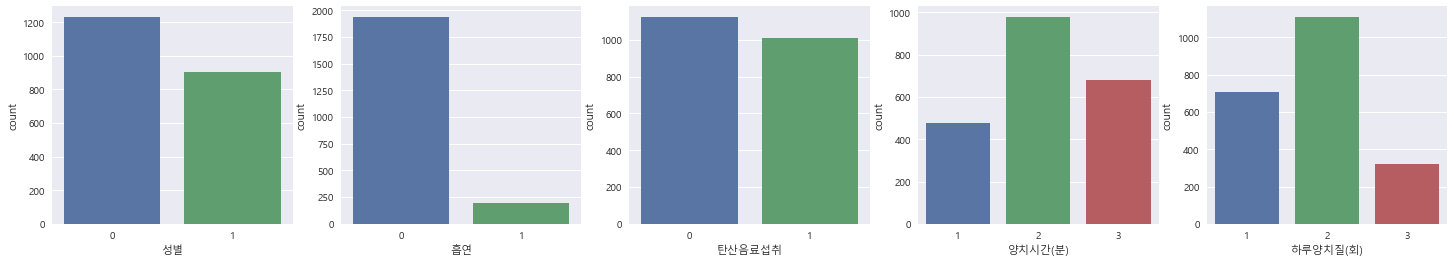

In [125]:
fig, ax = plt.subplots(ncols=5, figsize=(25,4))
sns.countplot(d1['성별'], ax=ax[0])
sns.countplot(d1['흡연'], ax=ax[1])
sns.countplot(d1['탄산음료섭취'], ax=ax[2])
sns.countplot(d1['양치시간(분)'], ax=ax[3])
sns.countplot(d1['하루양치질(회)'], ax=ax[4])

<AxesSubplot:xlabel='나이', ylabel='count'>

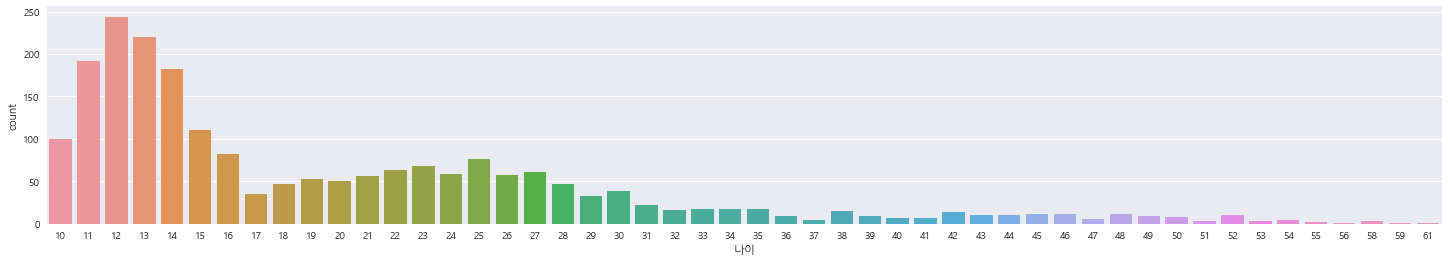

In [126]:
fig, ax = plt.subplots(figsize=(25,4))
sns.countplot(d1['나이'])

* 남성이 좀더 많음.
* 흡연은 안하는 사람이 매우 우세함.
* 탄산음료는 안마시는 사람이 좀더 많음.
* 양치시간은 2분, 양치회수는 2회가 가장 많음.
* 나이대는 10대가 가장 많음.

### 4-2-2 group_1,2
group 1,2은 크게 논의할 사항이 없음   
-> 습관이 어떻든지 간에 구강 상태가 안좋아서 찾은 사람  
: 이들도 나이 연령은 어떤지 나눌필요가 있음  
group 1의 점수가 높은  (점수가 표시된) 주요 habit도 확인할 필요성이 있습니다. 


In [134]:
# group_1,2의 특성 파악
d2 = df2[(df2['group']==1) | (df2['group']==2) ]

<AxesSubplot:xlabel='하루양치질(회)', ylabel='count'>

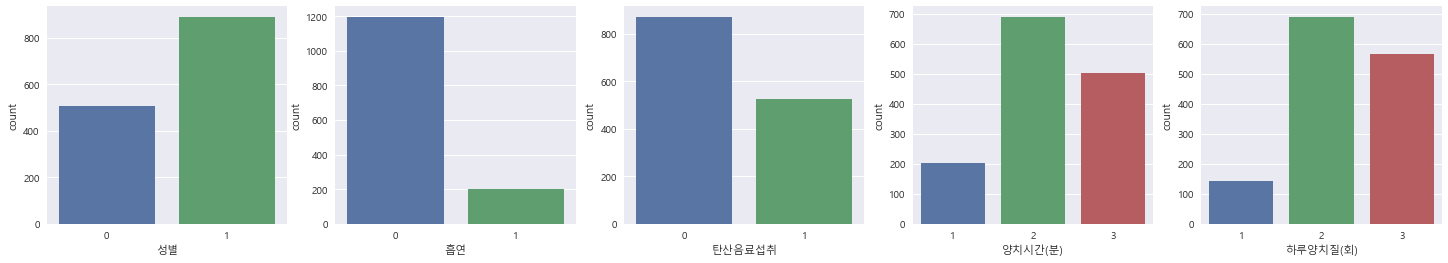

In [136]:
fig, ax = plt.subplots(ncols=5, figsize=(25,4))
sns.countplot(d2['성별'], ax=ax[0])
sns.countplot(d2['흡연'], ax=ax[1])
sns.countplot(d2['탄산음료섭취'], ax=ax[2])
sns.countplot(d2['양치시간(분)'], ax=ax[3])
sns.countplot(d2['하루양치질(회)'], ax=ax[4])

<AxesSubplot:xlabel='나이', ylabel='count'>

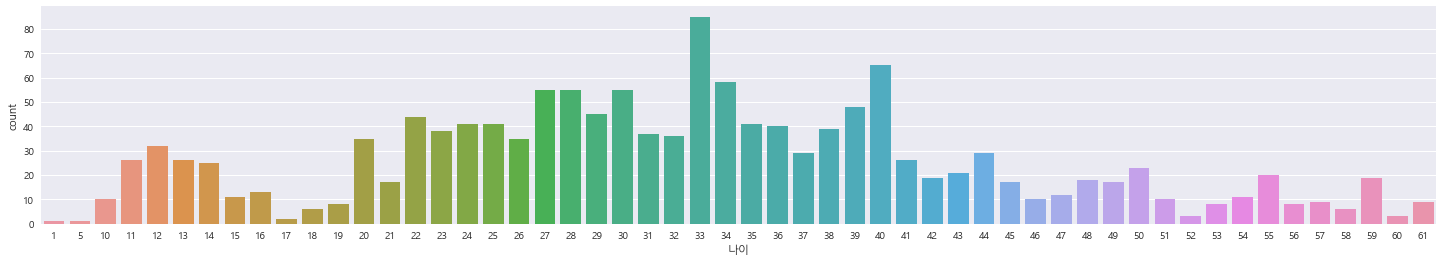

In [137]:
fig, ax = plt.subplots(figsize=(25,4))
sns.countplot(d2['나이'])

* 여성이 좀더 많음.
* 흡연은 안하는 사람이 매우 우세함.
* 탄산음료는 안마시는 사람이 좀더 많음.
* 양치시간은 2분, 양치회수는 2회가 가장 많음.
* 나이대는 20-30대에 거의 분포되어 있음.

### 4-2-3 group_3
group 3은 습관도 안 좋고 구강상태도 안좋아서 습관 개선이 필요한 집단  
: 지속적인 컨설팅과 추가 케어가 필요하기 때문에 2-3회 메세지를 더 보내도 되는 집단


In [138]:
# group_3의 특성 파악
d3 = df2[df2['group']==3]

<AxesSubplot:xlabel='하루양치질(회)', ylabel='count'>

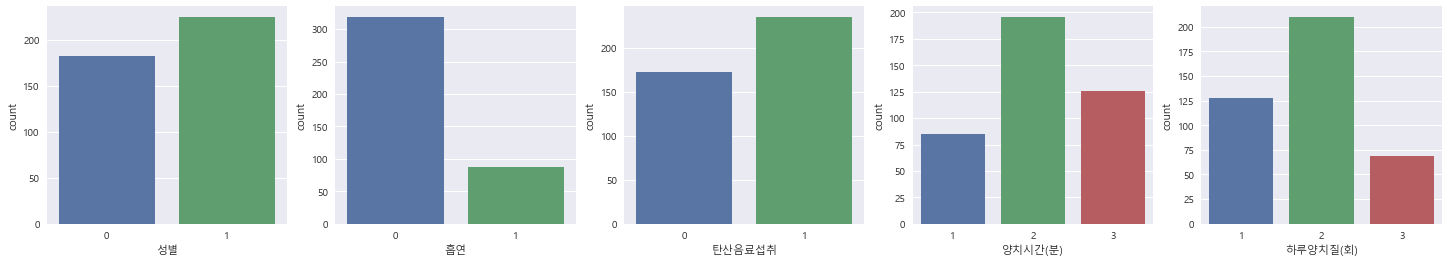

In [142]:
fig, ax = plt.subplots(ncols=5, figsize=(25,4))
sns.countplot(d3['성별'], ax=ax[0])
sns.countplot(d3['흡연'], ax=ax[1])
sns.countplot(d3['탄산음료섭취'], ax=ax[2])
sns.countplot(d3['양치시간(분)'], ax=ax[3])
sns.countplot(d3['하루양치질(회)'], ax=ax[4])

<AxesSubplot:xlabel='나이', ylabel='count'>

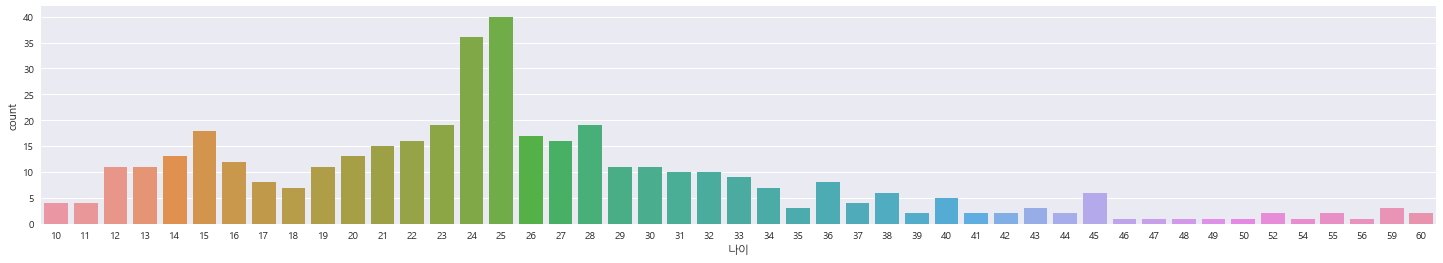

In [141]:
fig, ax = plt.subplots(figsize=(25,4))
sns.countplot(d3['나이'])

* 여성이 좀더 많음.
* 흡연은 안하는 사람이 매우 우세함.
* 탄산음료는 마시는사람이 좀더 많음.
* 양치시간은 2분, 양치회수는 2회가 가장 많음.
* 나이대는 20대에,10 대 순으로 거의 분포되어 있음.